In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 10d correlated Gaussian

I'm just taking the primer notebook I put together and using the 10d Gaussian as a testbed for the weighted PCA. This notebook is a little neater!

In [2]:
# Let's begin by obtaining some prior samples. I've chosen Unif(-1, 1) in all dimensions.

n = 10 # Number of dimensions.
n_prior = 200 # Number of prior samples
# Note the use of the key here. Jax uses this as opposed to your normal random seed. 
jax_prior_init = jax.random.uniform(key, shape=(n_prior, n), minval=-1, maxval=1)

In [3]:
'''
This is just a function to generate a covariance matrix for the Gaussian as a random sample from a Wishart
distribution, whilst ensuring the condition number is not too high.
'''
def get_icov(n, target=200, iseed=seed, eps=1, scale=50, just_do_it=False):
    condition = 0
    eigmax = np.inf
    this_seed = iseed
    if just_do_it:
        wish = scipy.stats.wishart(df=n, scale=np.eye(n)*scale, seed=this_seed)
        iC = wish.rvs(size=1)
        C = np.linalg.inv(iC)
        eigs = np.linalg.eigvals(C)
        eigmax,eigmin = eigs.max(), eigs.min()
        condition = eigmax / eigmin
    elif not just_do_it:
        while(abs(condition-target)>eps):
            wish = scipy.stats.wishart(df=n, scale=np.eye(n)*scale,seed=this_seed)
            iC = wish.rvs(size=1)
            C = np.linalg.inv(iC)
            eigs = np.linalg.eigvals(C)
            eigmax,eigmin = eigs.max(),eigs.min()
            condition = eigmax / eigmin
            this_seed += 1
    print("PSD: ",np.all(eigs>0))
    print("Condition number: ", condition)
    print("Op norm: ", eigmax)
    return iC, C

iCov, Cov = get_icov(n, eps=1)

PSD:  True
Condition number:  199.08320751596906
Op norm:  0.1587924033016887


In [4]:
'''
Define a function that returns the log-likelihood. First argument must be the variables you want to sample,
followed by any additional arguments.
'''
def log_like_cg(x, mu_diag=0, icov=iCov):
    n=x.shape[-1]
    mu = mu_diag * jnp.ones(n)
    return - 0.5 * jnp.dot((x - mu), jnp.dot(icov, (x - mu)))
'''
Define a function that returns the log-prior. As before, the first argument must the the variables you want to 
sample, followed by any additional arguments.
'''
def log_flat_prior(x, lower=-1, upper=1):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [5]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = ((jnp.array([-1]), jnp.array([1]))) 
inference_mode = 'sampling'
vmap = True
parallel_backend = None
bounds = np.array([-np.ones(n), np.ones(n)])
k_trunc = 0.5
random_seed = seed

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0.9, 0.9)
NBfirstlayer = True
verbose = False
interp_nbin = 5
iteration = 5
trainable_qw = False # Just leave this for now.
sgd_steps = 10
gamma = 0
knots_trainable = 5
optimize_directions = False
logp_cut = None
edge_bins = 0
Whiten = True
iteration = 5
NERCOME = False

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.1
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 2
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.9
reg1 = 0.9
mh_mode = 'IMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True

Now we can run our 10d Gaussian example.

In [6]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like_cg, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args, 
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             mh_mode=mh_mode,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             NERCOME=NERCOME,
                             sinf_resampled=sinf_resampled)

Inference mode is sampling. Maximum beta is set to 1.
min_delta_beta = 0.01
ESS for samples from most recent qw = 100
Updated beta = 0.0037841796875


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:385: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  weight_train=torch.from_numpy(np.asarray(self.train_weights[fit_idx, ...])),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:320: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torc

Time taken for trainable qw = 0.17407567299999993
Acceptance rate at IMH step 0: 0.615
Acceptance rate of original samples: 0.615
Time taken for trainable qw = 0.1802715389999996
Current qw ESS to target: 14
min_delta_beta = 0.01
ESS for samples from most recent qw = 100
Updated beta = 0.010424423962831497
Time taken for trainable qw = 0.16913422599999972
Acceptance rate at IMH step 0: 0.54
Acceptance rate of original samples: 0.54
Time taken for trainable qw = 0.15280047200000002
Current qw ESS to target: 18
min_delta_beta = 0.01
ESS for samples from most recent qw = 100
Updated beta = 0.022932131746756568
Time taken for trainable qw = 0.16641201299999953
Acceptance rate at IMH step 0: 0.305
Acceptance rate of original samples: 0.305
Time taken for trainable qw = 0.17023145699999986
Acceptance rate at IMH step 1: 0.245
Acceptance rate of original samples: 0.47
Time taken for trainable qw = 0.16095783399999952
Acceptance rate at IMH step 2: 0.21
Acceptance rate of original samples: 0.5

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [7]:
# Check the dictionary keys.
trace.keys()

dict_keys(['log_evidence', 'q_samples', 'importance_weights', 'logp', 'logq', 'train_logp', 'train_logq', 'logZ', 'q_models', 'q_ess', 'train_ess', 'total_ess', 'N', 'min_var_bws', 'min_pq_bws', '_t_sampling'])

In [8]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['q_models'][0]
q_models.keys()

dict_keys(['q1_w', 'q2_w', 'q3_w', 'q4_w', 'q5_w', 'q6_w', 'q7_w', 'q8_w', 'q9_w', 'q10_w', 'q11_w'])

In [9]:
# There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
q10 = q_models['q11_w']
# We can obtain samples from the q model as follows.
q_samples, logq = q10.sample(2000, device='cpu')
q_samples, logq = q_samples.numpy(), logq.numpy()
# And now we can calculate IW of these samples to the target.
logp = jax.vmap(lambda x: log_like_cg(x, np.zeros(n), iCov))(q_samples)
logw = logp - logq
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

In [10]:
# Function for plotting up the samples in a corner plot.

def plot_triangles(samples, weights, Cov, Ngd=1000, beta_idx=None,
                   out_name=None):

    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]
    
    truth = n_mvn.rvs(mean=np.zeros(n), cov=Cov, size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    samples_w = MCSamples(samples=samples, weights=weights,
                          names=names, labels=labels, 
                          label='posterior samples')

    # Triangle plot
    plt.figure()
    g = plots.get_subplot_plotter()
    g.triangle_plot([truth_gd, samples_w], filled=True)
    plt.show()
    if out_name is not None:
        g.export(out_name)

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

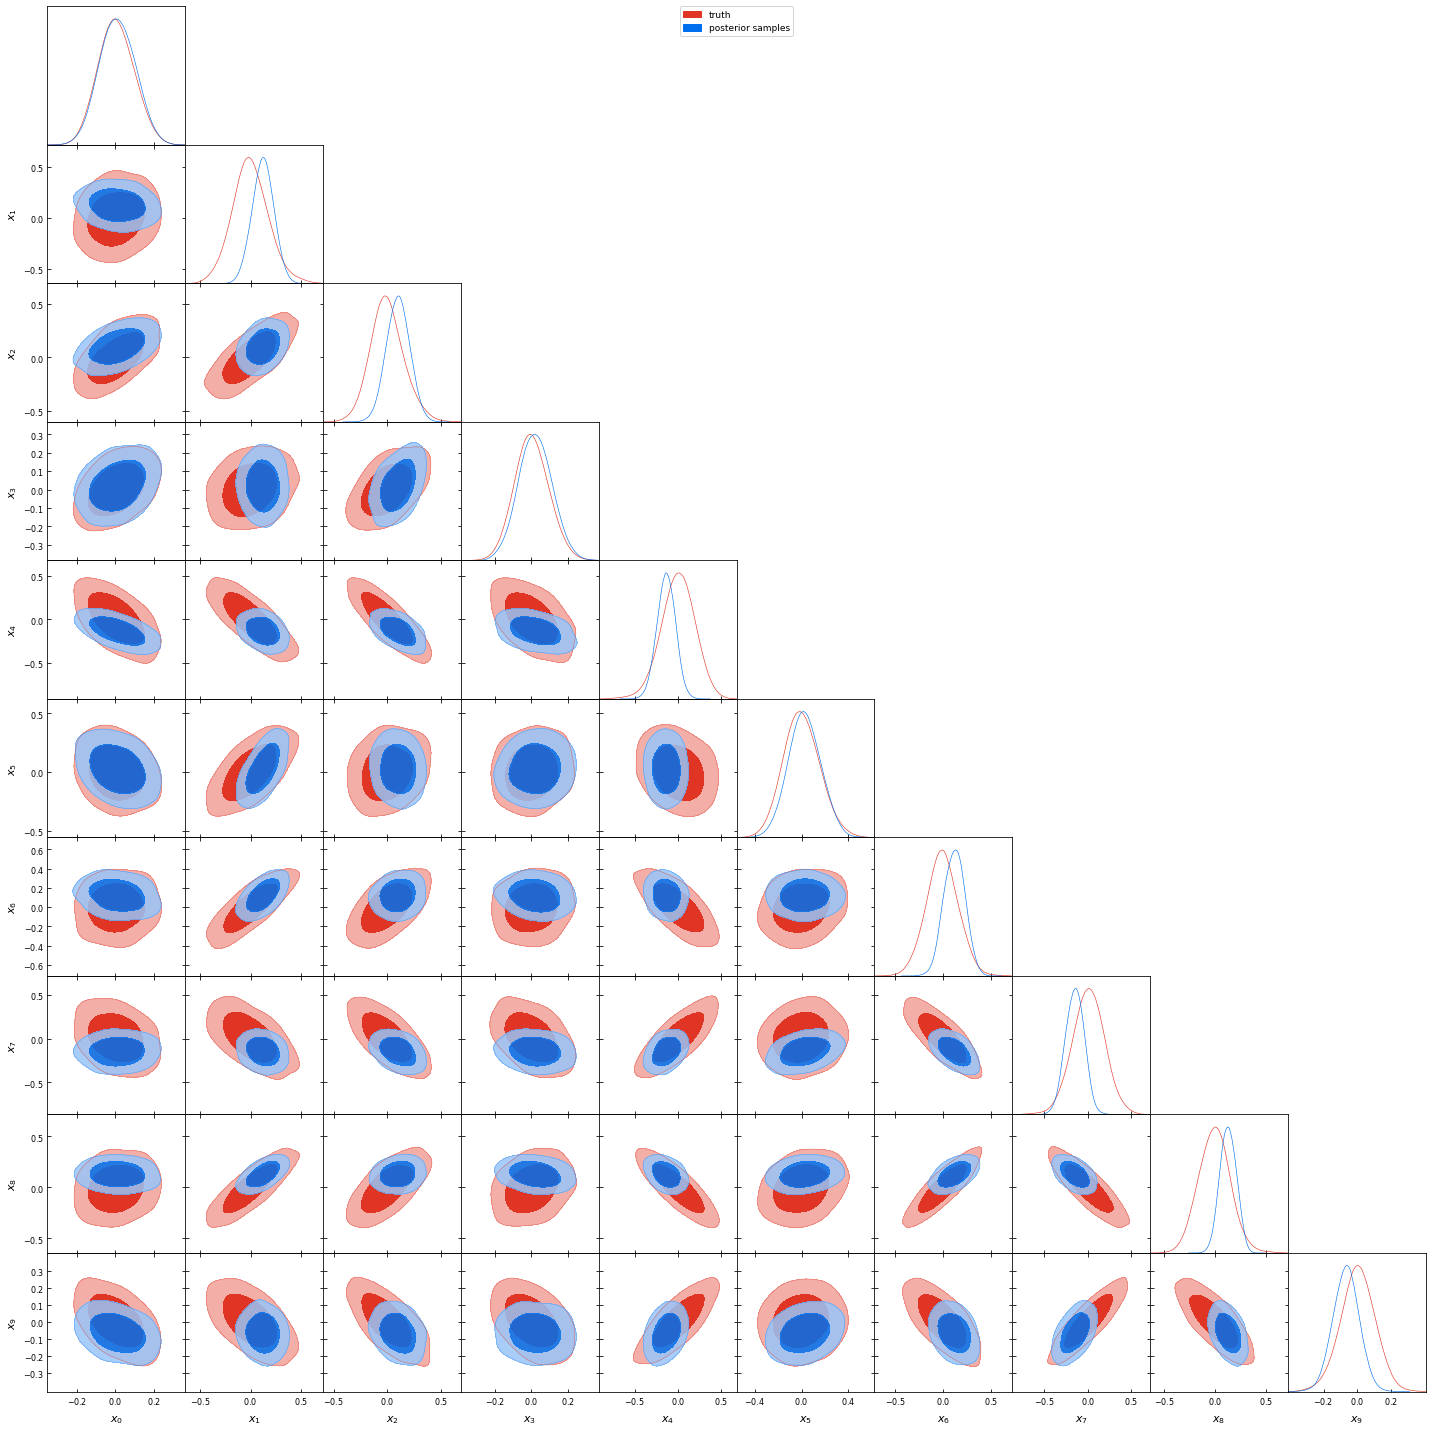

In [11]:
# First plot the samples without weights.
plot_triangles(q_samples, np.ones(len(q_samples)), Cov, out_name='resampled_sinf_fit_nercome_false.png')

In [ ]:
# Now plot the samples with their corresponding IW.
plot_triangles(q_samples, iw, Cov)

Removed no burn in
Removed no burn in
